In [1]:
!pip install git+https://github.com/bowang-lab/MedSAM.git

  Cloning https://github.com/bowang-lab/MedSAM.git to /tmp/pip-req-build-8puz1jex
  Running command git clone --filter=blob:none --quiet https://github.com/bowang-lab/MedSAM.git /tmp/pip-req-build-8puz1jex
  Resolved https://github.com/bowang-lab/MedSAM.git to commit 3b2283b61e2b58a0db2bcc43e5370a0c3c535916
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 17.3 MB/s eta 0:00:00
  Created wheel for medsam: filename=medsam-0.0.1-py3-none-any.whl size=36945 sha256=37ee28abe9e4522432c06f7543e84b00f11590763b4fe1f21b96eceec8f7fbe1
  Stored in directory: /tmp/pip-ephem-wheel-cache-9hj37pc0/wheels/d8/58/d0/a5f7456e7ae2b4e561cc9e0a065afeb4a9e2b7aa2fbc0fe80c
Successfully built medsam


In [2]:
# %% environment and functions
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
import torch
from segment_anything import sam_model_registry
from skimage import io, transform
import torch.nn.functional as F

# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))

@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed, # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )

    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg


In [3]:
# download model and data
img_id = '1Qf0IQF1zTwOJ4Fh4Ix5rtVhR9cnNbI2M'
!gdown $img_id
model_id = "1UAmWL88roYR7wKlnApw5Bcuzf2iQgk6_&confirm=t"
!gdown $model_id

Downloading...
From: https://drive.google.com/uc?id=1Qf0IQF1zTwOJ4Fh4Ix5rtVhR9cnNbI2M
To: /content/img_demo.png
100% 87.9k/87.9k [00:00<00:00, 100MB/s]
Downloading...
From: https://drive.google.com/uc?id=1UAmWL88roYR7wKlnApw5Bcuzf2iQgk6_
To: /content/medsam_vit_b.pth
100% 375M/375M [00:02<00:00, 129MB/s]


In [4]:
#%% load model and image
MedSAM_CKPT_PATH = "medsam_vit_b.pth"
device = "cuda:0"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()

img_np = io.imread('img_demo.png')
if len(img_np.shape) == 2:
    img_3c = np.repeat(img_np[:, :, None], 3, axis=-1)
else:
    img_3c = img_np
H, W, _ = img_3c.shape

In [5]:
#%% image preprocessing and model inference
img_1024 = transform.resize(img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
img_1024 = (img_1024 - img_1024.min()) / np.clip(
    img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
)  # normalize to [0, 1], (H, W, 3)
# convert the shape to (3, H, W)
img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)

box_np = np.array([[95,255, 190, 350]])
# transfer box_np t0 1024x1024 scale
box_1024 = box_np / np.array([W, H, W, H]) * 1024
with torch.no_grad():
    image_embedding = medsam_model.image_encoder(img_1024_tensor) # (1, 256, 64, 64)

medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, H, W)

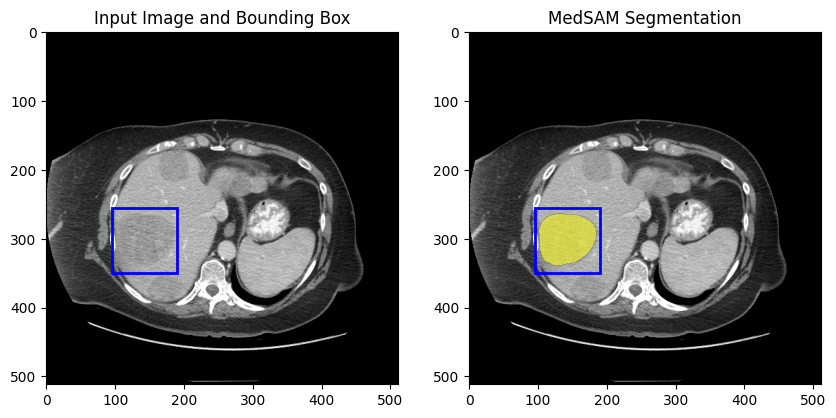

In [6]:
#%% visualize results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_3c)
show_box(box_np[0], ax[0])
ax[0].set_title("Input Image and Bounding Box")
ax[1].imshow(img_3c)
show_mask(medsam_seg, ax[1])
show_box(box_np[0], ax[1])
ax[1].set_title("MedSAM Segmentation")
plt.show()